In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import import_ipynb
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from utils import *

importing Jupyter notebook from utils.ipynb


In [2]:
df_train = pd.read_csv(train_csv_path, sep=",")
df_train["img_path"] =  df_train['image_id'].apply(build_image_path, convert_dtype=str)

df_test = pd.read_csv(test_csv_path, sep=",")
df_test["img_path"] =  df_test['image_id'].apply(build_image_path, convert_dtype=str)

In [3]:
# Vamos separar os dados em treinamento e validação na proporção 80/20:
df_train_split, df_val_split = train_test_split(df_train, test_size = 0.2, random_state = 123456, stratify = df_train[['cancer']])

print("Número de imagens no conjunto de treinamento: ", df_train_split.shape[0])
print("Distribuição de cancer conjunto de treinamento: ", df_train_split.groupby("cancer").agg(qtde=("site_id","count")).reset_index())
print("Número de imagens no conjunto de validação: ", df_val_split.shape[0])
print("Distribuição de cancer no conjunto de validação: ", df_val_split.groupby("cancer").agg(qtde=("site_id","count")).reset_index())
print("Número de imagens no conjunto de teste: ", df_test.shape[0])
print("Distribuição de cancer no conjunto de teste: ", df_test.groupby("cancer").agg(qtde=("site_id","count")).reset_index())

Número de imagens no conjunto de treinamento:  34995
Distribuição de cancer conjunto de treinamento:     cancer   qtde
0       0  34222
1       1    773
Número de imagens no conjunto de validação:  8749
Distribuição de cancer no conjunto de validação:     cancer  qtde
0       0  8556
1       1   193
Número de imagens no conjunto de teste:  10962
Distribuição de cancer no conjunto de teste:     cancer   qtde
0       0  10770
1       1    192


In [4]:
clean_all_datasets()

# Criando os diretórios:
create_dataset_dirs()
    
# Criando os subdiretórios
build_train_dataset_from_ori_imgs(df_train_split)
    
build_val_dataset_from_ori_imgs(df_val_split)

build_test_dataset_from_ori_imgs(df_test)

In [5]:
# Criando geradores de imagem para o tensorflow:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [6]:
class_names = ['normal', 'cancer']
target_size = (512, 512)

train_generator = train_datagen.flow_from_directory(
    train_dir_path,
    # classes = class_names,
    target_size = target_size,
    batch_size = 64,
    class_mode = 'binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
        train_dir_path,
        # classes = class_names,
        target_size = target_size,
        batch_size = 64,
        class_mode = 'binary',
        subset='validation')

test_generator = test_datagen.flow_from_directory(
        test_dir_path,
        # classes = class_names,
        target_size = target_size,
        batch_size = 64,
        class_mode = 'binary')

Found 27997 images belonging to 2 classes.
Found 6998 images belonging to 2 classes.
Found 10962 images belonging to 2 classes.


In [7]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model


model_resnet50 = ResNet50V2(weights = 'imagenet', input_shape = (target_size[0], target_size[1], 3), include_top = False)

for layer in model_resnet50.layers:
    layer.trainable = False
    
# build the entire model
x = model_resnet50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs = model_resnet50.input, outputs = predictions)

model.summary()



2023-07-04 23:42:54.181498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-04 23:42:54.243901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-04 23:42:54.244158: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [8]:
%load_ext tensorboard
from datetime import datetime

logs_dir = '/home/kasco/MDC/FinalProject/BreastCancerDetection/logs/baseline_resnet'

logdir = os.path.join(logs_dir, datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [9]:
from keras.optimizers import SGD, Adam

early_stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 20, )
save_model = tf.keras.callbacks.ModelCheckpoint(filepath = '../weights/baseline_resnet/weights.{epoch:02d}-{val_loss:.2f}.h5', monitor = "val_loss", mode = "min", save_best_only = True)

def trainModel(model, epochs, optimizer, callbacks = []):
    batch_size = 64
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model.fit(train_generator,
                     validation_data=validation_generator,
                      epochs=epochs,
                      steps_per_epoch = train_generator.samples // batch_size,
                      validation_steps = validation_generator.samples // batch_size,
                      batch_size=batch_size,
                      callbacks=callbacks)

sgd = SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
adam =  Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_history = trainModel(model = model, epochs = 500, optimizer = sgd, callbacks = [early_stopper, save_model, tensorboard_callback])

/home/kasco/anaconda3/envs/mdc-tf-gpu/lib/python3.9/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/kasco/anaconda3/envs/mdc-tf-gpu/lib/python3.9/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/500


2023-07-04 23:42:57.177343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-04 23:42:59.961740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-04 23:43:00.942881: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-04 23:43:01.332470: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-04 23:43:01.628222: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of me

437/437 [==============================] - ETA: 0s - loss: 0.5440 - accuracy: 0.7287

2023-07-04 23:46:58.670541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


437/437 [==============================] - 303s 677ms/step - loss: 0.5440 - accuracy: 0.7287 - val_loss: 0.1834 - val_accuracy: 0.9779
Epoch 2/500
437/437 [==============================] - 295s 673ms/step - loss: 0.3133 - accuracy: 0.8833 - val_loss: 0.1287 - val_accuracy: 0.9779
Epoch 3/500
437/437 [==============================] - 291s 665ms/step - loss: 0.2430 - accuracy: 0.9259 - val_loss: 0.1140 - val_accuracy: 0.9779
Epoch 4/500
437/437 [==============================] - 293s 671ms/step - loss: 0.2145 - accuracy: 0.9411 - val_loss: 0.1102 - val_accuracy: 0.9779
Epoch 5/500
437/437 [==============================] - 296s 676ms/step - loss: 0.1951 - accuracy: 0.9516 - val_loss: 0.1089 - val_accuracy: 0.9782
Epoch 6/500
437/437 [==============================] - 293s 671ms/step - loss: 0.1853 - accuracy: 0.9577 - val_loss: 0.1104 - val_accuracy: 0.9781
Epoch 7/500
437/437 [==============================] - 295s 674ms/step - loss: 0.1805 - accuracy: 0.9592 - val_loss: 0.1115 - val_

In [10]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

Text(0, 0.5, 'loss')

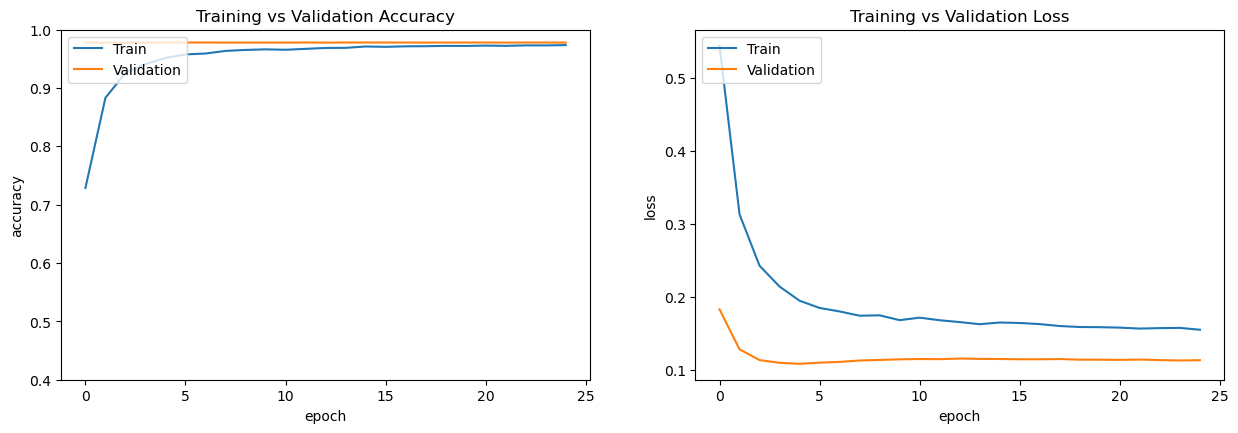

In [11]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

2023-07-05 06:30:06.329224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


172/172 [==============================] - 90s 523ms/step


Text(50.722222222222214, 0.5, 'Real')

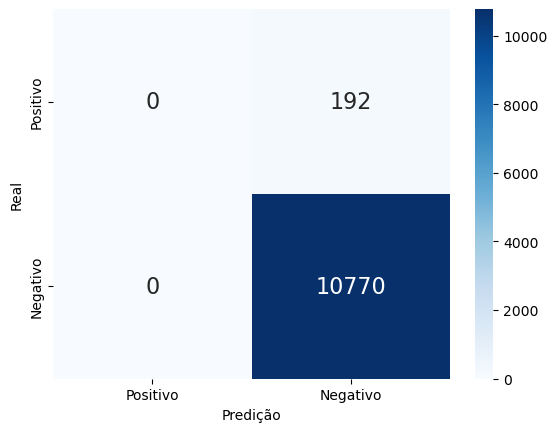

In [14]:
model_resnet50 = load_model('../weights/baseline_resnet/weights.05-0.11.h5')

pred_resnet50 = model_resnet50.predict(test_generator)

y_pred_resnet50 = []
for prob in pred_resnet50:
    if prob >= 0.5:
        y_pred_resnet50.append(1)
    else:
        y_pred_resnet50.append(0)
        
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_resnet50)

class_names = ['Positivo', 'Negativo']

ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

ax.set_xlabel("Predição")
ax.set_ylabel("Real")